--- Training Machine Learning Model: XGBoost with Backtesting & Timing ---
Dataset loaded successfully.

Starting backtesting process for accuracy metrics...

Training final XGBoost model on the entire dataset to measure time...
Final model training complete.

--- Average XGBoost Performance ---
  - Average MAE: 11.90
  - Average RMSE: 14.30
  - Average MAPE: 16.77%
  - Total Training Time: 0.09 seconds
  - Average Inference Speed: 0.0042 ms/prediction

--- Feature Importance ---


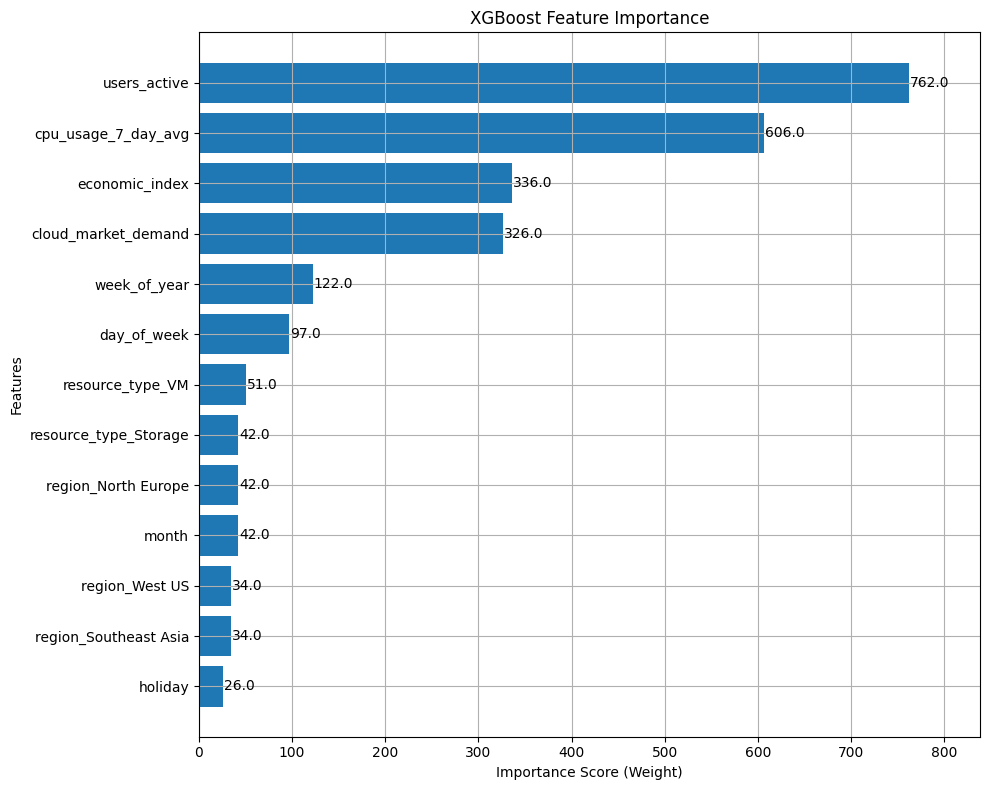


Saving the final trained XGBoost model...
Model successfully saved to: c:\Users\RAVI TEJA\OneDrive\Desktop\Infosys Internship 6.0\azure-demand-forecasting\models\xgboost_model.joblib


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

print("--- Training Machine Learning Model: XGBoost with Backtesting & Timing ---")

# --- Custom MAPE & Bias Functions ---
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def calculate_forecast_bias(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_true - y_pred)

# --- 1. Load Data ---
try:
    current_dir = os.getcwd()
    base_path = os.path.dirname(current_dir)
    data_path = os.path.join(base_path, 'data', 'processed', 'featured_dataset.csv')
    model_dir = os.path.join(base_path, 'models')
    model_path = os.path.join(model_dir, 'xgboost_model.joblib')
    df = pd.read_csv(data_path, parse_dates=['date'])
    df = df.sort_values('date')
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- 2. Prepare Data ---
df_processed = pd.get_dummies(df, columns=['region', 'resource_type'], drop_first=True)
features = [col for col in df_processed.columns if col not in ['date', 'usage_cpu', 'usage_storage', 'year_week']]
target = 'usage_cpu'
X = df_processed[features]
y = df_processed[target]

# --- 3. Backtesting (for accuracy metrics) ---
print("\nStarting backtesting process for accuracy metrics...")
split_points = [pd.to_datetime('2023-02-01'), pd.to_datetime('2023-03-01')]
all_metrics = []
# ... (Backtesting loop remains the same)
for i, split_point in enumerate(split_points):
    fold_num = i + 1
    train_end_date = split_point - pd.DateOffset(days=1)
    test_start_date = split_point
    test_end_date = split_point + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    train_mask = (df_processed['date'] <= train_end_date)
    test_mask = (df_processed['date'] >= test_start_date) & (df_processed['date'] <= test_end_date)
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    if len(X_test) == 0: continue
    xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
    xgboost_model.fit(X_train, y_train)
    predictions = xgboost_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mape = calculate_mape(y_test, predictions)
    bias = calculate_forecast_bias(y_test, predictions)
    all_metrics.append({'mae': mae, 'rmse': rmse, 'mape': mape, 'bias': bias})

# --- 4. Train Final Model on All Data & Measure Time ---
print("\nTraining final XGBoost model on the entire dataset to measure time...")
final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)

start_time = time.time()
final_model.fit(X, y)
end_time = time.time()
training_time = end_time - start_time
print("Final model training complete.")

# --- 5. Measure Inference Speed ---
inference_start_time = time.time()
# Predict on the entire dataset to get a stable average
final_model.predict(X)
inference_end_time = time.time()
inference_speed = (inference_end_time - inference_start_time) / len(X)


# --- 6. Display Average Backtesting Results & Timing ---
if all_metrics:
    avg_mae = np.mean([m['mae'] for m in all_metrics])
    avg_rmse = np.mean([m['rmse'] for m in all_metrics])
    avg_mape = np.mean([m['mape'] for m in all_metrics])

    print("\n--- Average XGBoost Performance ---")
    print(f"  - Average MAE: {avg_mae:.2f}")
    print(f"  - Average RMSE: {avg_rmse:.2f}")
    print(f"  - Average MAPE: {avg_mape:.2f}%")
    print(f"  - Total Training Time: {training_time:.2f} seconds")
    print(f"  - Average Inference Speed: {inference_speed * 1000:.4f} ms/prediction")
else:
    print("\nNo backtesting folds were completed.")


# --- 7. Plot Feature Importance & Save Final Model ---
print("\n--- Feature Importance ---")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(final_model, ax=ax, height=0.8, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score (Weight)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nSaving the final trained XGBoost model...")
os.makedirs(model_dir, exist_ok=True)
joblib.dump(final_model, model_path)
print(f"Model successfully saved to: {model_path}")

